In [53]:
import sys
import os

current_dir = os.getcwd()  # dir corrente
root_path = os.path.abspath(os.path.join(current_dir, '..')) # path per dir principale
sys.path.append(root_path)

from imports import *

In [54]:
with open('/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/dfs_train_list.pkl', 'rb') as file:
    dfs_train = pickle.load(file)

In [55]:
new_dfs_train = []

for df in dfs_train:
 
    numero_di_parti = len(df) // 400
    # ottini 3 df, 0-400, 400-800, 800-1200
    for i in range(numero_di_parti):
        parte = df.iloc[i*400 : (i+1)*400]
        new_dfs_train.append(parte)

In [56]:
new_dfs_train[0]

,TIME,P1,P2,P3,P4,P5,P6,P7,Case
0,0.000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1
1,0.001,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1
2,0.002,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1
3,0.003,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1
4,0.004,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1
...,...,...,...,...,...,...,...,...,...
395,0.395,2.000177,2.003238,2.002017,2.006795,2.003013,1.996481,2.008814,1
396,0.396,2.027547,2.039730,2.044473,2.045197,2.045520,2.032143,2.044309,1
397,0.397,2.047702,2.073731,2.077465,2.076979,2.073962,2.080573,2.078629,1
398,0.398,2.056113,2.088829,2.099895,2.106574,2.096731,2.097748,2.098754,1


In [57]:
path_dataframes="/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/dataframes"


In [58]:
df_train = pd.read_csv(f"{path_dataframes}/df_train_task3.csv")
df_test = pd.read_csv(f"{path_dataframes}/df_test_task3.csv")

df_labels = pd.read_csv(f"{path_dataframes}/df_labels_train.csv")
# df_train = df_train.drop(columns="Unnamed: 0")
# df_labels = df_labels.drop(columns="Unnamed: 0")

In [59]:
df_train 

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0,0.442692,0.724545,0.728887,0.302783,0.297822,0.317366,0.590160,3.824206e-01,0.129474,...,0.552726,0.584951,0.582910,0.465241,0.513837,0.01227,0.465241,0.534149,0.524858,0.243697
1,1,0.942380,0.785278,0.735861,0.317851,0.311983,0.373316,0.638933,3.616752e-01,0.161884,...,0.512717,0.437503,0.433336,0.425134,0.367830,0.01227,0.425134,0.453405,0.392997,0.487395
2,2,0.943969,0.793574,0.736092,0.317440,0.311860,0.371919,0.638514,3.616923e-01,0.161620,...,0.512744,0.436894,0.432733,0.425161,0.367345,0.01227,0.425161,0.452900,0.392443,0.487395
3,3,0.438839,0.723314,0.726877,0.302556,0.289849,0.383880,0.625447,3.775594e-01,0.128729,...,0.568203,0.606595,0.604689,0.481062,0.537658,0.01227,0.481062,0.547643,0.539004,0.554622
4,4,0.942394,0.823747,0.733827,0.317670,0.304123,0.383480,0.698345,3.567968e-01,0.161299,...,0.579662,0.516670,0.514242,0.492888,0.447986,0.01227,0.492888,0.516919,0.436149,0.617647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,526,0.045665,0.314880,0.297516,0.980204,0.161322,0.507897,0.265517,0.000000e+00,0.691587,...,0.364665,0.142278,0.143025,0.286197,0.111415,0.00000,0.286197,0.097679,0.177124,0.105042
527,527,0.049514,0.321749,0.297640,0.980081,0.161177,0.508719,0.261302,6.212933e-07,0.691376,...,0.364683,0.142425,0.143164,0.286213,0.111622,0.00000,0.286213,0.097774,0.177369,0.105042
528,528,0.442130,0.453373,0.434133,0.164398,0.099745,0.674815,0.241775,5.017391e-01,0.036502,...,0.526981,0.633538,0.636324,0.439304,0.567719,0.01227,0.439304,0.293440,0.602601,0.147059
529,529,0.313744,0.466544,0.431662,0.165687,0.100016,0.739933,0.184579,5.011974e-01,0.052996,...,0.497343,0.568978,0.570232,0.410022,0.501503,0.01227,0.410022,0.240455,0.552014,0.315126


In [60]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
1,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
2,2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
3,3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
4,4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,173,3,3,100,100,100,100,0,0,0,1,0,0,0,0,1
173,173,174,3,3,100,100,100,100,0,0,0,0,1,0,0,0,1
174,174,175,3,3,100,100,100,100,0,0,0,0,0,1,0,0,1
175,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1


In [61]:
# df_triplicato = pd.DataFrame(np.tile(df_labels.values, (3, 1)), columns=df_labels.columns)

In [62]:
df_triplicato = pd.DataFrame()

for index, row in df_labels.iterrows():
    repeated_rows = pd.DataFrame(np.tile(row.values, (3, 1)), columns=df_labels.columns)
    df_triplicato = pd.concat([df_triplicato, repeated_rows], ignore_index=True)

In [63]:
# df_triplicato[df_triplicato["binary_condition"]!=0]

In [64]:
column_to_number = {
    'BP1': 1,
    'BP2': 2,
    'BP3': 3,
    'BP4': 4,
    'BP5': 5,
    'BP6': 6,
    'BP7': 7,
    'BV1': 8
}

df_triplicato['anomaly_location'] = 0

for index, row in df_triplicato.iterrows():
    for col in column_to_number.keys():
        if row[col] == 1:
            df_triplicato.at[index, 'anomaly_location'] = column_to_number[col]
            break  

# df_labels = df_labels[153:]

In [65]:
idx = df_triplicato.index.values

In [66]:
df_triplicato

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,anomaly_location
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
3,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
4,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1,7
527,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1,7
528,176,177,3,3,100,100,100,100,0,0,0,0,0,0,0,1,1,8
529,176,177,3,3,100,100,100,100,0,0,0,0,0,0,0,1,1,8


In [67]:
df_train["bubble_location"] = df_triplicato["anomaly_location"]

In [68]:
df_train = df_train[df_train["bubble_location"] != 0]
df_triplicato = df_triplicato[df_triplicato["anomaly_location"] != 0]

In [69]:
df_triplicato

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,anomaly_location
459,153,154,1,3,100,100,100,100,1,0,0,0,0,0,0,0,1,1
460,153,154,1,3,100,100,100,100,1,0,0,0,0,0,0,0,1,1
461,153,154,1,3,100,100,100,100,1,0,0,0,0,0,0,0,1,1
462,154,155,1,3,100,100,100,100,0,1,0,0,0,0,0,0,1,2
463,154,155,1,3,100,100,100,100,0,1,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1,7
527,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1,7
528,176,177,3,3,100,100,100,100,0,0,0,0,0,0,0,1,1,8
529,176,177,3,3,100,100,100,100,0,0,0,0,0,0,0,1,1,8


In [70]:
df_train

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth,bubble_location
459,459,0.452129,0.256501,0.600005,0.107172,0.024760,0.529002,0.527536,4.023474e-01,0.072748,...,0.761232,0.753368,0.202294,0.700967,0.012270,0.202294,0.374542,1.000000,0.016807,1
460,460,0.319117,0.192545,0.594064,0.111743,0.028076,0.535564,0.487026,4.011110e-01,0.089257,...,0.710226,0.702347,0.192939,0.644914,0.012270,0.192939,0.336501,0.937804,0.016807,1
461,461,0.319795,0.196871,0.594307,0.111629,0.028178,0.535357,0.488876,4.010557e-01,0.089291,...,0.711389,0.703577,0.194621,0.646319,0.012270,0.194621,0.338051,0.937591,0.016807,1
462,462,0.416985,0.375305,0.987565,0.174560,0.908963,0.260310,0.635246,5.798805e-01,0.821963,...,0.764376,0.756776,0.699341,0.705380,0.012270,0.699341,0.689624,0.558238,0.592437,2
463,463,0.615662,0.324542,0.997434,0.176306,0.913415,0.229975,0.775072,5.723223e-01,0.816869,...,0.816005,0.802751,0.628367,0.767782,0.018405,0.628367,0.676991,0.665339,0.037815,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,526,0.045665,0.314880,0.297516,0.980204,0.161322,0.507897,0.265517,0.000000e+00,0.691587,...,0.142278,0.143025,0.286197,0.111415,0.000000,0.286197,0.097679,0.177124,0.105042,7
527,527,0.049514,0.321749,0.297640,0.980081,0.161177,0.508719,0.261302,6.212933e-07,0.691376,...,0.142425,0.143164,0.286213,0.111622,0.000000,0.286213,0.097774,0.177369,0.105042,7
528,528,0.442130,0.453373,0.434133,0.164398,0.099745,0.674815,0.241775,5.017391e-01,0.036502,...,0.633538,0.636324,0.439304,0.567719,0.012270,0.439304,0.293440,0.602601,0.147059,8
529,529,0.313744,0.466544,0.431662,0.165687,0.100016,0.739933,0.184579,5.011974e-01,0.052996,...,0.568978,0.570232,0.410022,0.501503,0.012270,0.410022,0.240455,0.552014,0.315126,8


In [71]:
df_train = df_train.drop(columns=["index","bubble_location"])

In [72]:
df_train

,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,P1_fft_variance,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
459,0.452129,0.256501,0.600005,0.107172,0.024760,0.529002,0.527536,4.023474e-01,0.072748,0.555363,...,0.267132,0.761232,0.753368,0.202294,0.700967,0.012270,0.202294,0.374542,1.000000,0.016807
460,0.319117,0.192545,0.594064,0.111743,0.028076,0.535564,0.487026,4.011110e-01,0.089257,0.549208,...,0.255829,0.710226,0.702347,0.192939,0.644914,0.012270,0.192939,0.336501,0.937804,0.016807
461,0.319795,0.196871,0.594307,0.111629,0.028178,0.535357,0.488876,4.010557e-01,0.089291,0.549459,...,0.257867,0.711389,0.703577,0.194621,0.646319,0.012270,0.194621,0.338051,0.937591,0.016807
462,0.416985,0.375305,0.987565,0.174560,0.908963,0.260310,0.635246,5.798805e-01,0.821963,0.985280,...,0.766073,0.764376,0.756776,0.699341,0.705380,0.012270,0.699341,0.689624,0.558238,0.592437
463,0.615662,0.324542,0.997434,0.176306,0.913415,0.229975,0.775072,5.723223e-01,0.816869,0.996958,...,0.704718,0.816005,0.802751,0.628367,0.767782,0.018405,0.628367,0.676991,0.665339,0.037815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,0.045665,0.314880,0.297516,0.980204,0.161322,0.507897,0.265517,0.000000e+00,0.691587,0.258641,...,0.364665,0.142278,0.143025,0.286197,0.111415,0.000000,0.286197,0.097679,0.177124,0.105042
527,0.049514,0.321749,0.297640,0.980081,0.161177,0.508719,0.261302,6.212933e-07,0.691376,0.258755,...,0.364683,0.142425,0.143164,0.286213,0.111622,0.000000,0.286213,0.097774,0.177369,0.105042
528,0.442130,0.453373,0.434133,0.164398,0.099745,0.674815,0.241775,5.017391e-01,0.036502,0.388438,...,0.526981,0.633538,0.636324,0.439304,0.567719,0.012270,0.439304,0.293440,0.602601,0.147059
529,0.313744,0.466544,0.431662,0.165687,0.100016,0.739933,0.184579,5.011974e-01,0.052996,0.386028,...,0.497343,0.568978,0.570232,0.410022,0.501503,0.012270,0.410022,0.240455,0.552014,0.315126


In [73]:
def feature_selection_chi2(df_X, df_y, n_features):
    X = df_X
    y = df_y

    chi2_selector = SelectKBest(chi2, k=n_features)
    chi2_selector.fit(X, y)

    scores = chi2_selector.scores_
    selected_features = chi2_selector.get_support(indices=True)
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)
    
    top_features = feature_scores.head(n_features)
    features = top_features["Feature"].values
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Chi-Square Scores')
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Feature')
    plt.show()

    return features


In [74]:
def feature_selection_anova(df_X,df_y,n_features):
    X = df_X
    y = df_y
    
    f_values, p_values = f_classif(X, y)

    results = pd.DataFrame({'Feature': X.columns, 'F_Value': f_values, 'P_Value': p_values})

    results = results.sort_values(by='F_Value', ascending=False)

    top_features = results.head(n_features)
    features = top_features["Feature"].values
    # features=np.concatenate([features, ["binary_condition"]])

    plt.figure(figsize=(8, 6))
    plt.barh(top_features["Feature"], top_features["F_Value"], color='skyblue')
    plt.xlabel('F-Value')
    plt.ylabel('Feature')
    plt.title('features selection ANOVA')
    plt.gca().invert_yaxis() 
    plt.show()
    return features

In [75]:
def feature_selection_random_forest(df_X, df_y, n_features):
    X = df_X
    y = df_y

    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X, y)

    importances = rf_model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    top_features = feature_importances.head(n_features)
    features = top_features["Feature"].values

    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Random Forest Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.show()

    return features

In [76]:
# df_labels = df_labels[154:]
# df_train = df_train[154:]

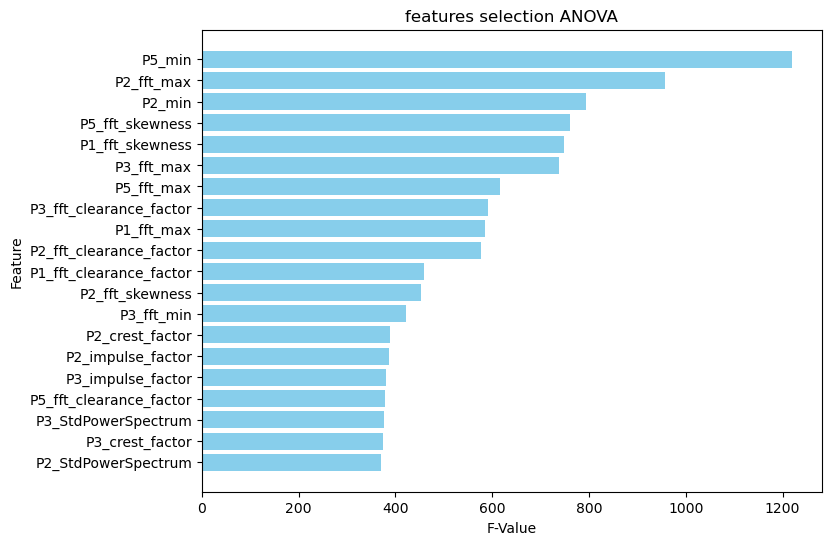

In [77]:
features_anova_train = feature_selection_anova(df_train,df_triplicato["anomaly_location"],20)


In [78]:
df_train = df_train[features_anova_train]
df_test = df_test[features_anova_train]



In [79]:
df_train = df_train[features_anova_train]


In [80]:
# df_train[105:]

In [81]:
# df_labels[105:]

In [82]:

num_locations = df_triplicato["anomaly_location"].unique()
num_locations = sorted(num_locations)
print(num_locations)

X_train, X_test, y_train, y_test = train_test_split(df_train, df_triplicato["anomaly_location"], test_size=0.3,random_state=123)

[1, 2, 3, 4, 5, 6, 7, 8]


In [83]:
y_test

522    6
485    1
530    8
524    6
482    8
467    3
511    2
523    6
488    2
513    3
468    4
503    7
496    5
499    6
529    8
460    1
502    7
501    7
509    1
473    5
483    1
521    5
Name: anomaly_location, dtype: int64

In [84]:
y_train

478    7
490    3
465    3
512    2
518    4
510    2
474    6
520    5
477    7
472    5
481    8
469    4
519    5
470    4
459    1
464    2
517    4
471    5
504    8
493    4
486    2
489    3
480    8
492    4
497    5
487    2
494    4
500    6
466    3
507    1
527    7
515    3
528    8
498    6
479    7
461    1
462    2
514    3
508    1
463    2
475    6
526    7
495    5
484    1
505    8
491    3
506    8
516    4
476    6
525    7
Name: anomaly_location, dtype: int64

In [85]:
confusion_matrices = []

map_location = {1: "BP1", 2: "BP2", 3: "BP3", 4: "BP4", 5: "BP5", 6: "BP6", 7: "BP7", 8: "BV1"}
models = []

# Definizione della grid search
param_grid = {
    'n_estimators': [50, 100, 200],

}

for location in num_locations:
    print("------------------------------------------")
    print(f"{map_location[location]}")
    print("------------------------------------------")

    y_binary_train = y_train == location

    # Definizione del modello e della grid search
    model = RandomForestClassifier(random_state=123)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, scoring='accuracy')

    # Addestramento del modello
    grid_search.fit(X_train, y_binary_train)
    
    best_model = grid_search.best_estimator_
    models.append([best_model, location])

    # Predizione sul test set
    y_pred_binary = best_model.predict(X_test)

    # Matrice di confusione e report di classificazione
    cm_train = confusion_matrix(y_binary_train, best_model.predict(X_train))
    confusion_matrices.append(cm_train)

    y_binary_test = y_test == location
    cm_test = confusion_matrix(y_binary_test, y_pred_binary)

    report = classification_report(y_binary_test, y_pred_binary)
    print(f"Classification Report for location {map_location[location]} on Test Set:")
    print(report)

    print(f"Confusion Matrix for location {map_location[location]} on Test Set:")
    print(cm_test)

predictions = []
for model in models:
    rf_model = model[0]
    pred = rf_model.predict(X_test)
    predictions.append(pred)

# print(confusion_matrices)


------------------------------------------
BP1
------------------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Classification Report for location BP1 on Test Set:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        18
        True       1.00      1.00      1.00         4

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

Confusion Matrix for location BP1 on Test Set:
[[18  0]
 [ 0  4]]
------------------------------------------
BP2
------------------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Classification Report for location BP2 on Test Set:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        20
        True       1.00      1.00      1.00         2

    accuracy                           1.

In [86]:
with open(f'{path_dataframes}/index_test_anomaly_task2.pkl', 'rb') as file:
    anomaly_idx = pickle.load(file)


In [87]:
anomaly_idx

array([178, 186, 193, 196, 204, 216, 219, 221])

In [88]:
numbers = np.repeat(np.arange(178, 224), 3)
print(numbers)
# Assegna i primi 531 elementi alla nuova colonna
df_test['Case'] = numbers[:531]

[178 178 178 179 179 179 180 180 180 181 181 181 182 182 182 183 183 183
 184 184 184 185 185 185 186 186 186 187 187 187 188 188 188 189 189 189
 190 190 190 191 191 191 192 192 192 193 193 193 194 194 194 195 195 195
 196 196 196 197 197 197 198 198 198 199 199 199 200 200 200 201 201 201
 202 202 202 203 203 203 204 204 204 205 205 205 206 206 206 207 207 207
 208 208 208 209 209 209 210 210 210 211 211 211 212 212 212 213 213 213
 214 214 214 215 215 215 216 216 216 217 217 217 218 218 218 219 219 219
 220 220 220 221 221 221 222 222 222 223 223 223]


In [89]:
df_test

,P5_min,P2_fft_max,P2_min,P5_fft_skewness,P1_fft_skewness,P3_fft_max,P5_fft_max,P3_fft_clearance_factor,P1_fft_max,P2_fft_clearance_factor,...,P2_fft_skewness,P3_fft_min,P2_crest_factor,P2_impulse_factor,P3_impulse_factor,P5_fft_clearance_factor,P3_StdPowerSpectrum,P3_crest_factor,P2_StdPowerSpectrum,Case
0,0.065815,0.893357,0.877493,0.721917,0.821963,0.781085,0.788492,0.686406,0.908963,0.846925,...,0.825357,0.367033,0.870963,0.870180,0.739811,0.789788,0.579456,0.745586,0.789934,178
1,0.048778,0.899852,0.878541,0.725835,0.816869,0.793020,0.793664,0.688266,0.913415,0.848743,...,0.830571,0.376939,0.878395,0.877584,0.752848,0.790470,0.581564,0.759447,0.792720,178
2,0.048361,0.899899,0.878698,0.726374,0.816718,0.793058,0.793881,0.688303,0.913357,0.848772,...,0.830662,0.376911,0.878323,0.877508,0.752753,0.790536,0.581616,0.759360,0.792782,178
3,0.007863,0.407617,0.008540,0.231840,0.131567,0.352132,0.449710,0.333061,0.340405,0.420350,...,0.280348,0.556169,0.439989,0.439046,0.387239,0.459164,0.297620,0.391436,0.391419,179
4,0.003815,0.450607,0.007866,0.249762,0.160219,0.365606,0.457922,0.335059,0.352964,0.428131,...,0.381021,0.567548,0.402174,0.401114,0.374096,0.460804,0.289654,0.378396,0.368197,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2.046569,0.123229,1.264230,-0.111879,-0.230002,0.139436,0.101560,0.412991,0.047216,0.449579,...,-0.090734,0.164471,0.295905,0.284969,0.265527,0.400358,0.563721,0.282643,0.630796,222
134,2.048250,0.123324,1.264120,-0.111874,-0.229984,0.139529,0.101604,0.413095,0.047329,0.449693,...,-0.090696,0.164377,0.295902,0.284964,0.265511,0.400459,0.563822,0.282628,0.630912,222
135,0.007574,0.168496,0.014106,0.112318,0.079141,0.147935,0.200316,0.226178,0.073442,0.305063,...,0.151582,0.529521,0.502254,0.503582,0.416312,0.274503,0.228647,0.416177,0.335014,223
136,0.003281,0.185948,0.013048,0.142478,0.117427,0.164475,0.211308,0.227722,0.089709,0.302637,...,0.195018,0.545215,0.474974,0.475954,0.398265,0.275206,0.215688,0.398423,0.313607,223


In [90]:
# new_index_values = range(178, 224)
# df_test.reset_index(drop=True, inplace=True)
# df_test.index = new_index_values

In [91]:
df_test = df_test[df_test["Case"].isin(anomaly_idx)]

In [92]:
cases = df_test["Case"].values

In [93]:
df_test = df_test.drop(columns="Case")

In [94]:
print(models)

[[RandomForestClassifier(n_estimators=50, random_state=123), 1], [RandomForestClassifier(random_state=123), 2], [RandomForestClassifier(random_state=123), 3], [RandomForestClassifier(n_estimators=50, random_state=123), 4], [RandomForestClassifier(n_estimators=50, random_state=123), 5], [RandomForestClassifier(n_estimators=50, random_state=123), 6], [RandomForestClassifier(random_state=123), 7], [RandomForestClassifier(n_estimators=50, random_state=123), 8]]


In [95]:
predictions = []
for model in models:
    print(model)
    rf_model = model[0]
    pred = rf_model.predict(df_test)
    predictions.append(pred)

[RandomForestClassifier(n_estimators=50, random_state=123), 1]
[RandomForestClassifier(random_state=123), 2]
[RandomForestClassifier(random_state=123), 3]
[RandomForestClassifier(n_estimators=50, random_state=123), 4]
[RandomForestClassifier(n_estimators=50, random_state=123), 5]
[RandomForestClassifier(n_estimators=50, random_state=123), 6]
[RandomForestClassifier(random_state=123), 7]
[RandomForestClassifier(n_estimators=50, random_state=123), 8]


In [96]:
true_indices = [np.where(arr)[0] for arr in predictions]
true_indices

[array([6, 7, 8]),
 array([ 0,  1,  2, 21, 22, 23]),
 array([12, 13, 14]),
 array([ 9, 10, 11]),
 array([18, 19, 20]),
 array([3, 4, 5]),
 array([], dtype=int64),
 array([], dtype=int64)]

In [97]:
predictions


[array([False, False, False, False, False, False,  True,  True,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]),
 array([ True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True,  True]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True,  True, False, False, False,
        False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False, False,
         True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True,  True,  True, False, False, False]),
 array([False, False, False,  

In [98]:
final_indices = []
idx = []

for array in predictions:
    indices = np.where(array == True)[0]
    idx.append(indices)
    final_indices.extend(indices)


# print(final_indices)
print(idx)
# final_indices_sorted = sorted(final_indices)

[array([6, 7, 8]), array([ 0,  1,  2, 21, 22, 23]), array([12, 13, 14]), array([ 9, 10, 11]), array([18, 19, 20]), array([3, 4, 5]), array([], dtype=int64), array([], dtype=int64)]


In [99]:
df_test_tmp = df_test.reset_index()

In [100]:
df_test_tmp

,index,P5_min,P2_fft_max,P2_min,P5_fft_skewness,P1_fft_skewness,P3_fft_max,P5_fft_max,P3_fft_clearance_factor,P1_fft_max,...,P1_fft_clearance_factor,P2_fft_skewness,P3_fft_min,P2_crest_factor,P2_impulse_factor,P3_impulse_factor,P5_fft_clearance_factor,P3_StdPowerSpectrum,P3_crest_factor,P2_StdPowerSpectrum
0,0,0.065815,0.893357,0.877493,0.721917,0.821963,0.781085,0.788492,0.686406,0.908963,...,0.874743,0.825357,0.367033,0.870963,0.870180,0.739811,0.789788,0.579456,0.745586,0.789934
1,1,0.048778,0.899852,0.878541,0.725835,0.816869,0.793020,0.793664,0.688266,0.913415,...,0.876613,0.830571,0.376939,0.878395,0.877584,0.752848,0.790470,0.581564,0.759447,0.792720
2,2,0.048361,0.899899,0.878698,0.726374,0.816718,0.793058,0.793881,0.688303,0.913357,...,0.876601,0.830662,0.376911,0.878323,0.877508,0.752753,0.790536,0.581616,0.759360,0.792782
3,24,0.591636,0.215843,0.048454,0.492438,0.578675,0.193070,0.311983,0.133970,0.198889,...,0.194464,0.610889,0.755823,0.215095,0.212225,0.173668,0.253352,0.061031,0.179642,0.082709
4,25,0.650257,0.203385,0.036298,0.452594,0.547764,0.176604,0.294898,0.131046,0.184220,...,0.192139,0.579453,0.742837,0.229718,0.226809,0.186530,0.247662,0.059146,0.192927,0.087628
5,26,0.650114,0.204337,0.036883,0.452744,0.547953,0.176764,0.295031,0.130889,0.184247,...,0.191921,0.581087,0.743317,0.228669,0.225747,0.185927,0.247424,0.058960,0.192330,0.087072
6,45,0.007574,0.003920,0.518342,0.000000,0.072748,0.017309,0.023234,0.206855,0.024760,...,0.361198,0.000000,0.419137,0.613416,0.611067,0.534911,0.216598,0.219919,0.542437,0.299516
7,46,0.013596,0.011872,0.427636,0.018404,0.089257,0.020507,0.021941,0.207767,0.028076,...,0.360929,0.026188,0.421004,0.610525,0.608178,0.531049,0.216295,0.216296,0.538859,0.298181
8,47,0.013335,0.012111,0.426930,0.018332,0.089291,0.020558,0.021829,0.207835,0.028178,...,0.361050,0.026541,0.420933,0.610308,0.607958,0.530997,0.216327,0.216321,0.538817,0.298102
9,54,0.007856,0.506252,0.108991,0.340951,0.488712,0.444167,0.360385,0.520488,0.444866,...,0.581442,0.459318,0.303205,0.734800,0.733600,0.657692,0.477404,0.438523,0.660525,0.544851


In [101]:

map_location_pred = { 0: "BP1", 1: "BP2", 2: "BP3", 3: "BP4", 4: "BP5", 5: "BP6", 6: "BP7", 7: "BV1"}


for index, row in df_test_tmp.iterrows():
    for i, values_pred in enumerate(idx):
        flag = True
        print("index_pred",i)

        for e in values_pred:
           
            if index == e:
                print(f"------------ Elem {e}")
                print(e)
            
             
                # if index == 2:
                    
                df_test_tmp.at[index, "Condition"] = map_location_pred[i]
                # else:
                #     df_test_tmp.at[index, "Condition"] = map_location[i]
                if(flag):
                    print("location: ",map_location_pred[i])
                    print("values_pred",values_pred)
                    flag = False

index_pred 0
index_pred 1
------------ Elem 0
0
location:  BP2
values_pred [ 0  1  2 21 22 23]
index_pred 2
index_pred 3
index_pred 4
index_pred 5
index_pred 6
index_pred 7
index_pred 0
index_pred 1
------------ Elem 1
1
location:  BP2
values_pred [ 0  1  2 21 22 23]
index_pred 2
index_pred 3
index_pred 4
index_pred 5
index_pred 6
index_pred 7
index_pred 0
index_pred 1
------------ Elem 2
2
location:  BP2
values_pred [ 0  1  2 21 22 23]
index_pred 2
index_pred 3
index_pred 4
index_pred 5
index_pred 6
index_pred 7
index_pred 0
index_pred 1
index_pred 2
index_pred 3
index_pred 4
index_pred 5
------------ Elem 3
3
location:  BP6
values_pred [3 4 5]
index_pred 6
index_pred 7
index_pred 0
index_pred 1
index_pred 2
index_pred 3
index_pred 4
index_pred 5
------------ Elem 4
4
location:  BP6
values_pred [3 4 5]
index_pred 6
index_pred 7
index_pred 0
index_pred 1
index_pred 2
index_pred 3
index_pred 4
index_pred 5
------------ Elem 5
5
location:  BP6
values_pred [3 4 5]
index_pred 6
index_pred 

In [102]:
df_test_tmp["real_case"]=cases

In [103]:
df_test_tmp = df_test_tmp.rename(columns={"index":"Case"})

In [104]:
df_test_tmp[["Case","Condition","real_case"]]

,Case,Condition,real_case
0,0,BP2,178
1,1,BP2,178
2,2,BP2,178
3,24,BP6,186
4,25,BP6,186
5,26,BP6,186
6,45,BP1,193
7,46,BP1,193
8,47,BP1,193
9,54,BP4,196
